In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [3]:
np.random.seed(8)

In [4]:
sp500_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_list = sp500_df['Symbol'].sample(n=3).tolist()

In [5]:
start_date = '2010-01-01'
end_date = '2020-12-31'
prices_df = yf.download(sp500_list, start=start_date, end=end_date)['Adj Close']
prices_df.dropna(axis=1, inplace=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
print(prices_df.head())

[*********************100%%**********************]  3 of 3 completed

Downloaded 2768 rows of data.
Ticker           JKHY          L        TMO
Date                                       
2010-01-04  19.794746  34.312244  45.235546
2010-01-05  19.479353  34.496819  45.387924
2010-01-06  19.446157  34.736755  45.816471
2010-01-07  19.429560  34.995167  45.816471
2010-01-08  19.255266  34.967464  46.587868


In [6]:
ticker = np.random.choice(prices_df.columns)
data = prices_df[ticker].reset_index()
data.columns = ['Date', 'Close']
data = data[['Date', 'Close']]
data = data.dropna()

In [7]:
model_arima = pm.auto_arima(data['Close'], start_p=1, start_q=1, max_p=5, max_q=5, seasonal=False, d=1,
                            trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
fc_arima, confint_arima = model_arima.predict(n_periods=len(data) + 12 * 4, return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14096.358, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14138.569, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14098.217, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14101.085, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14142.929, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14097.944, Time=0.89 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14097.588, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14098.832, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14096.630, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14091.323, Time=0.71 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14044.697, Time=1.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14075.629, Time=0.53 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=14039.589, Time=0.96 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=14056.576, Time=0.75 sec
 ARIMA(5,1,2)(0,0,0

In [8]:
model_sarimax = SARIMAX(data['Close'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
results_sarimax = model_sarimax.fit()
fc_sarimax = results_sarimax.forecast(steps=len(data) + 12 * 4)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67994D+00    |proj g|=  9.65200D-02

At iterate    5    f=  2.56678D+00    |proj g|=  2.61663D-02

At iterate   10    f=  2.54526D+00    |proj g|=  3.01962D-03

At iterate   15    f=  2.54461D+00    |proj g|=  5.52050D-04

At iterate   20    f=  2.54460D+00    |proj g|=  7.90216D-04

At iterate   25    f=  2.54453D+00    |proj g|=  1.75124D-03

At iterate   30    f=  2.54445D+00    |proj g|=  1.75771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [9]:
mse_arima = mean_squared_error(data['Close'], fc_arima[:len(data)])
mse_sarimax = mean_squared_error(data['Close'], fc_sarimax[:len(data)])
print(f'MSE for ARIMA: {mse_arima}')
print(f'MSE for SARIMAX: {mse_sarimax}')

MSE for ARIMA: 262318.1177317276
MSE for SARIMAX: 415809.87779349


In [10]:
if mse_arima < mse_sarimax:
    selected_model = model_arima
    fc_selected = fc_arima
else:
    selected_model = model_sarimax
    fc_selected = fc_sarimax

In [11]:
fc_final, confint_final = selected_model.predict(n_periods=12 * 10, return_conf_int=True)
future_dates = pd.date_range(start=end_date, periods=12 * 10, freq='M')

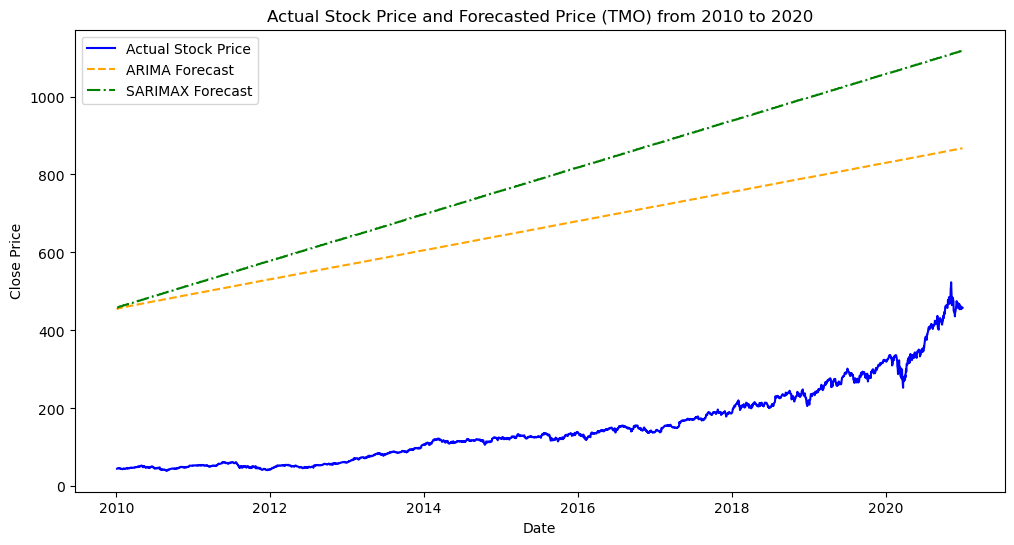

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Actual Stock Price', color='blue')
plt.plot(data['Date'], fc_arima[:len(data)], label='ARIMA Forecast', color='orange', linestyle='--')
plt.plot(data['Date'], fc_sarimax[:len(data)], label='SARIMAX Forecast', color='green', linestyle='-.')
plt.title(f'Actual Stock Price and Forecasted Price ({ticker}) from 2010 to 2020')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

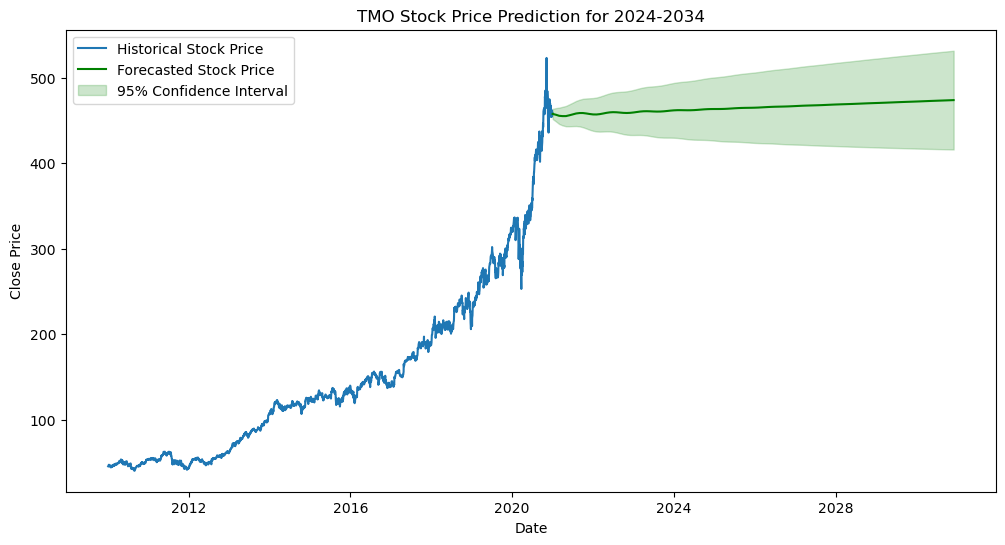

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Historical Stock Price')
plt.plot(future_dates, fc_final, label='Forecasted Stock Price', color='green')
plt.fill_between(future_dates, confint_final[:, 0], confint_final[:, 1], alpha=0.2, color='green', label='95% Confidence Interval')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction for 2024-2034')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()